In [11]:
import os
import shutil
import random
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


In [12]:
# Define dataset paths
synthetic_art_path = pathlib.Path('/kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2')
authentic_indian_path = pathlib.Path('/kaggle/input/art-images-clear-and-distorted/Art_Dataset_Clear/Indian')
authentic_foreign_path = pathlib.Path('/kaggle/input/art-images-clear-and-distorted/Art_Dataset_Clear/Foreign')

# Organize dataset directories
dataset_structure = {
    "SyntheticArt": [synthetic_art_path],
    "AuthenticArt": [authentic_indian_path, authentic_foreign_path]
}

def enumerate_image_files(directory_list):
    """Count and collect all image files from given directories"""
    file_collection = []
    for dir_path in directory_list:
        collected_files = list(dir_path.glob('*'))
        file_collection.extend(collected_files)
    return file_collection

# Collect images from both categories
synthetic_collection = enumerate_image_files(dataset_structure['SyntheticArt'])
authentic_collection = enumerate_image_files(dataset_structure['AuthenticArt'])

print(f"Synthetic artwork samples: {len(synthetic_collection)}")
print(f"Authentic artwork samples: {len(authentic_collection)}")

Synthetic artwork samples: 17857
Authentic artwork samples: 17020


In [13]:
def validate_and_filter_oversized_images(target_directory, max_pixel_threshold=200000000):
    """Identify and remove images exceeding pixel threshold"""
    oversized_files = []
    corrupted_files = []
    
    for root_dir, _, filenames in os.walk(target_directory):
        for filename in filenames:
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                complete_path = os.path.join(root_dir, filename)
                try:
                    with Image.open(complete_path) as img_object:
                        if img_object.size[0] * img_object.size[1] > max_pixel_threshold:
                            oversized_files.append(complete_path)
                            os.remove(complete_path)
                            print(f"Eliminated oversized file: {complete_path} (dimensions: {img_object.size})")
                except Exception as error:
                    print(f"Processing error for {complete_path}: {error}")
                    corrupted_files.append(complete_path)
                    print(f"Eliminated corrupted file: {complete_path}")
    
    return oversized_files, corrupted_files

In [15]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = None  # disables the decompression bomb protection


# Initialize collections for file validation
valid_image_paths = []
corresponding_labels = []
removed_oversized_list = []
removed_corrupted_list = []

# Validate image integrity across all categories
for category_name, directory_paths in dataset_structure.items():
    for current_path in directory_paths:
        print(f"Validating images in {current_path}")
        jpg_files = list(current_path.glob('*.jpg'))
        png_files = list(current_path.glob('*.png'))
        all_images = jpg_files + png_files
        
        for image_file in all_images:
            try:
                with Image.open(image_file) as img_validator:
                    img_validator.verify()
                    valid_image_paths.append(image_file)
                    corresponding_labels.append(category_name)
            except (IOError, SyntaxError) as validation_error:
                print(f"Invalid image detected: {image_file}, Error: {validation_error}")
                removed_corrupted_list.append(image_file)

# Process each directory for oversized images
for directory_list in dataset_structure.values():
    for single_directory in directory_list:
        oversized_imgs, corrupted_imgs = validate_and_filter_oversized_images(single_directory)
        removed_oversized_list.extend(oversized_imgs)
        removed_corrupted_list.extend(corrupted_imgs)

# Filter out problematic images from main collections
cleaned_paths = []
cleaned_labels = []

for file_path, category_label in zip(valid_image_paths, corresponding_labels):
    if str(file_path) not in removed_oversized_list and str(file_path) not in removed_corrupted_list:
        cleaned_paths.append(str(file_path))
        cleaned_labels.append(category_label)

final_image_paths = np.array(cleaned_paths)
final_labels = np.array(cleaned_labels)

# Validate data consistency
if len(final_image_paths) != len(final_labels):
    raise ValueError(f"Data mismatch detected: {len(final_image_paths)} images vs {len(final_labels)} labels.")


Validating images in /kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2
Validating images in /kaggle/input/art-images-clear-and-distorted/Art_Dataset_Clear/Indian
Validating images in /kaggle/input/art-images-clear-and-distorted/Art_Dataset_Clear/Foreign
Processing error for /kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2/12479.jpg: [Errno 30] Read-only file system: '/kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2/12479.jpg'
Eliminated corrupted file: /kaggle/input/dalle-recognition-dataset/fakeV2/fake-v2/12479.jpg


In [16]:
# Combine all image collections with labels
complete_image_list = synthetic_collection + authentic_collection
complete_label_list = ['SyntheticArt'] * len(synthetic_collection) + ['AuthenticArt'] * len(authentic_collection)

# Convert paths to strings for dataframe compatibility
string_paths = [str(path_obj) for path_obj in complete_image_list]

# Create comprehensive dataset dataframe
dataset_df = pd.DataFrame({"image_file": string_paths, "category": complete_label_list})

# Balance dataset by taking minimum class size
smallest_class_size = min(dataset_df['category'].value_counts())

# Create balanced dataset through sampling
balanced_dataset = dataset_df.groupby('category').apply(lambda group: group.sample(smallest_class_size)).reset_index(drop=True)

# Split into train/validation/test sets
training_validation_split, testing_split = train_test_split(balanced_dataset, test_size=0.10, random_state=42, shuffle=True)

training_split, validation_split = train_test_split(training_validation_split, test_size=0.11, random_state=42, shuffle=True)  # ~10% of original

# Configure data augmentation for training
training_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Configure normalization for validation and testing
validation_preprocessing = ImageDataGenerator(rescale=1./255)
testing_preprocessing = ImageDataGenerator(rescale=1./255)

# Create data generators
training_flow = training_augmentation.flow_from_dataframe(
    dataframe=training_split,
    x_col="image_file",
    y_col="category",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=200
)

validation_flow = validation_preprocessing.flow_from_dataframe(
    dataframe=validation_split,
    x_col="image_file",
    y_col="category",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=200
)

testing_flow = testing_preprocessing.flow_from_dataframe(
    dataframe=testing_split,
    x_col="image_file",
    y_col="category",
    target_size=(224, 224),
    class_mode='binary',
    batch_size=200
)

# Display dataset distribution
print(f"Training samples: {len(training_split)}")
print(f"Validation samples: {len(validation_split)}")
print(f"Testing samples: {len(testing_split)}")


/tmp/ipykernel_398/2151489439.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_dataset = dataset_df.groupby('category').apply(lambda group: group.sample(smallest_class_size)).reset_index(drop=True)


Found 27265 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_file". These filename(s) will be ignored.
  warnings.warn(


Found 3369 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="image_file". These filename(s) will be ignored.
  warnings.warn(


Found 3404 validated image filenames belonging to 2 classes.
Training samples: 27266
Validation samples: 3370
Testing samples: 3404


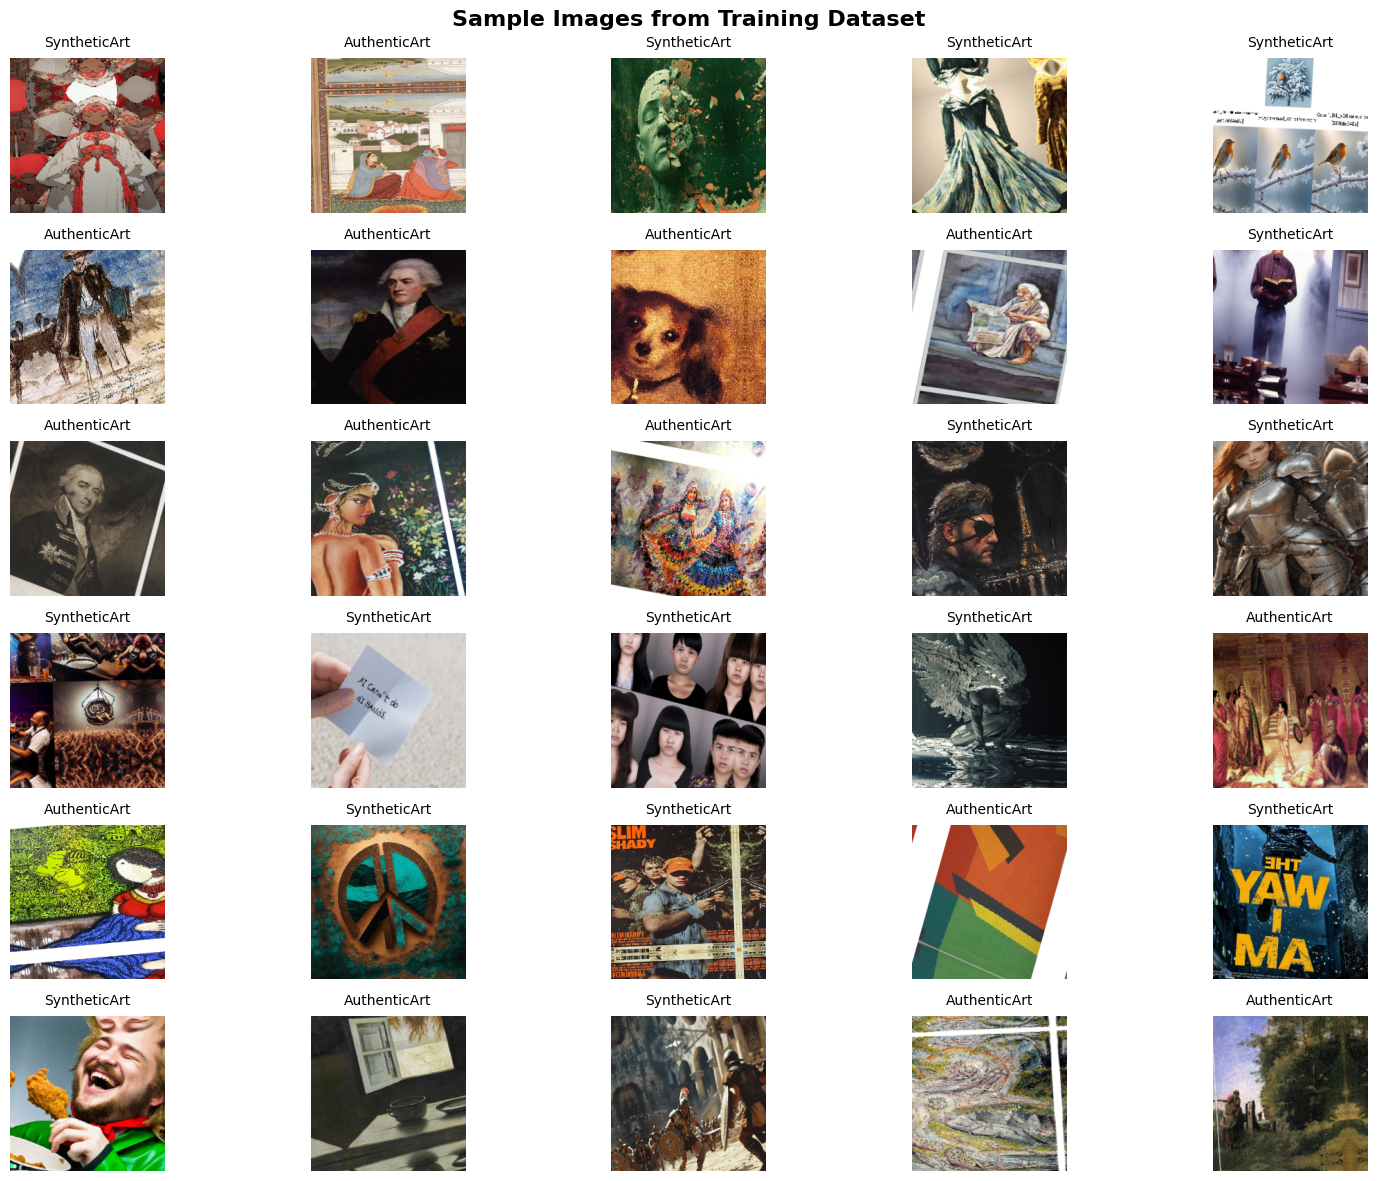

In [10]:
# Visualize sample images from training set
sample_images, sample_labels = next(training_flow)
category_names = list(training_flow.class_indices.keys())

plt.figure(figsize=(16, 12))
plt.suptitle('Sample Images from Training Dataset', fontsize=16, fontweight='bold')

for idx in range(30):
    subplot_position = plt.subplot(6, 5, idx + 1)
    plt.imshow(sample_images[idx])
    plt.title(f'{category_names[int(sample_labels[idx])]}', fontsize=10, pad=8)
    plt.axis("off")
    # Add subtle border around each subplot
    for spine in subplot_position.spines.values():
        spine.set_edgecolor('lightgray')
        spine.set_linewidth(0.5)

plt.tight_layout()
plt.show()

## Fine-tuned MobileNet Architecture (Version 1)

In [11]:
pretrained_mobilenet_v1 = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pretrained_mobilenet_v1.summary()

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "mobilenet_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,228,864 (12.32 MB)

 Trainable params: 3,206,976 (12.23 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [12]:
# Build custom classification head
feature_vector = pretrained_mobilenet_v1.output
pooled_features = GlobalAveragePooling2D()(feature_vector)
normalized_features = BatchNormalization()(pooled_features)
regularized_features = Dropout(0.3)(normalized_features)

# Final classification layer
binary_output = Dense(1, activation='sigmoid')(regularized_features)

# Complete model assembly
mobilenet_v1_classifier = Model(inputs=pretrained_mobilenet_v1.input, outputs=binary_output)

# Enable fine-tuning
pretrained_mobilenet_v1.trainable = True

# Configure optimizer and loss
mobilenet_v1_classifier.compile(optimizer=Adam(learning_rate=1e-5),
                               loss='binary_crossentropy',
                               metrics=['accuracy'])

# Setup training callbacks
model_checkpoint_v1 = ModelCheckpoint('MobileNetV1_custom_classifier.keras', 
                                     monitor='val_loss', save_best_only=True, verbose=1)
learning_rate_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-10)

# Train the model
training_history_v1 = mobilenet_v1_classifier.fit(
    training_flow,
    steps_per_epoch=training_flow.samples // training_flow.batch_size,
    validation_data=validation_flow,
    validation_steps=validation_flow.samples // validation_flow.batch_size,
    epochs=20,
    callbacks=[model_checkpoint_v1, learning_rate_scheduler]
)

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1755029120.617283     107 service.cc:145] XLA service 0x7b71dc003c90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755029120.617341     107 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1755029151.315911     107 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  3/136 ━━━━━━━━━━━━━━━━━━━━ 6:11 3s/step - accuracy: 0.4200 - loss: 1.2056   

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.6208 - loss: 0.7514
Epoch 1: val_loss improved from inf to 0.33519, saving model to MobileNetV1_custom_classifier.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 849s 6s/step - accuracy: 0.6217 - loss: 0.7498 - val_accuracy: 0.8606 - val_loss: 0.3352 - learning_rate: 1.0000e-05
Epoch 2/20
  1/136 ━━━━━━━━━━━━━━━━━━━━ 50s 371ms/step - accuracy: 0.8600 - loss: 0.3875

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss improved from 0.33519 to 0.30158, saving model to MobileNetV1_custom_classifier.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - accuracy: 0.8600 - loss: 0.3875 - val_accuracy: 0.8639 - val_loss: 0.3016 - learning_rate: 1.0000e-05
Epoch 3/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8844 - loss: 0.2762
Epoch 3: val_loss improved from 0.30158 to 0.21829, saving model to MobileNetV1_custom_classifier.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 771s 5s/step - accuracy: 0.8845 - loss: 0.2760 - val_accuracy: 0.9150 - val_loss: 0.2183 - learning_rate: 1.0000e-05
Epoch 4/20
  1/136 ━━━━━━━━━━━━━━━━━━━━ 50s 373ms/step - accuracy: 0.9300 - loss: 0.2125
Epoch 4: val_loss improved from 0.21829 to 0.21160, saving model to MobileNetV1_custom_classifier.keras
136/136 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.9300 - loss: 0.2125 - val_accuracy: 0.9290 - val_loss: 0.2116 - learning_rate: 1.0000e-05
Epoch 5/20
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9189 - los

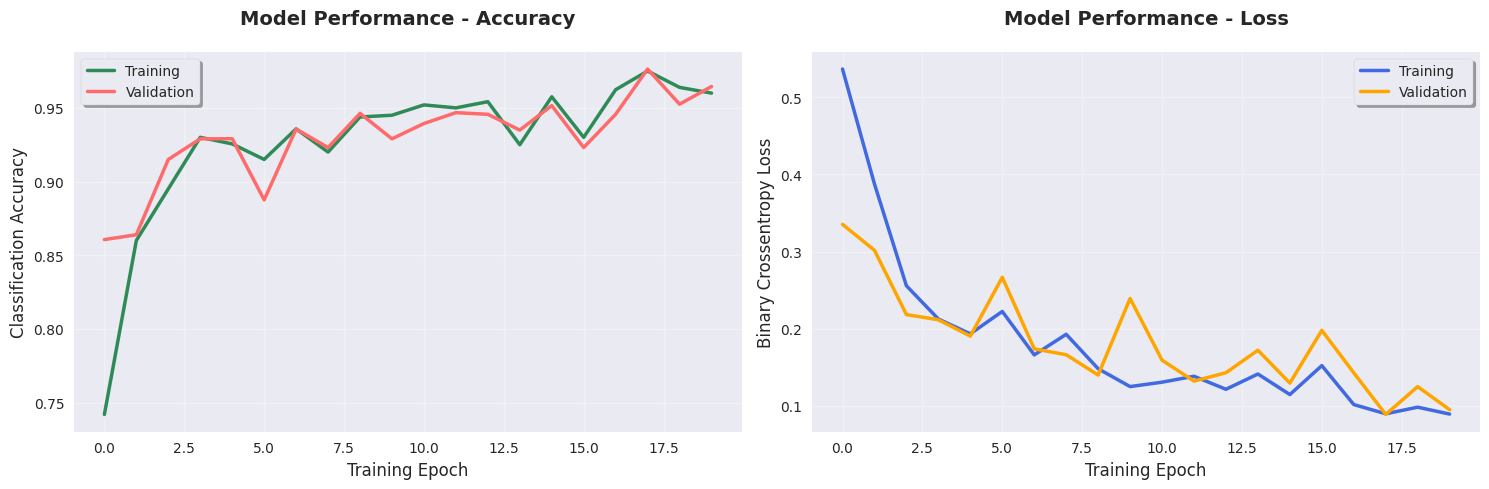

In [13]:
# Visualize training progress with enhanced styling
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy plot with gradient background
ax1.plot(training_history_v1.history['accuracy'], linewidth=2.5, color='#2E8B57', label='Training')
ax1.plot(training_history_v1.history['val_accuracy'], linewidth=2.5, color='#FF6B6B', label='Validation')
ax1.set_title('Model Performance - Accuracy', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Training Epoch', fontsize=12)
ax1.set_ylabel('Classification Accuracy', fontsize=12)
ax1.legend(frameon=True, shadow=True)
ax1.grid(True, alpha=0.3)

# Loss plot with different styling
ax2.plot(training_history_v1.history['loss'], linewidth=2.5, color='#4169E1', label='Training')
ax2.plot(training_history_v1.history['val_loss'], linewidth=2.5, color='#FFA500', label='Validation')
ax2.set_title('Model Performance - Loss', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Training Epoch', fontsize=12)
ax2.set_ylabel('Binary Crossentropy Loss', fontsize=12)
ax2.legend(frameon=True, shadow=True)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classification Result: Class 0, Confidence: 0.00%


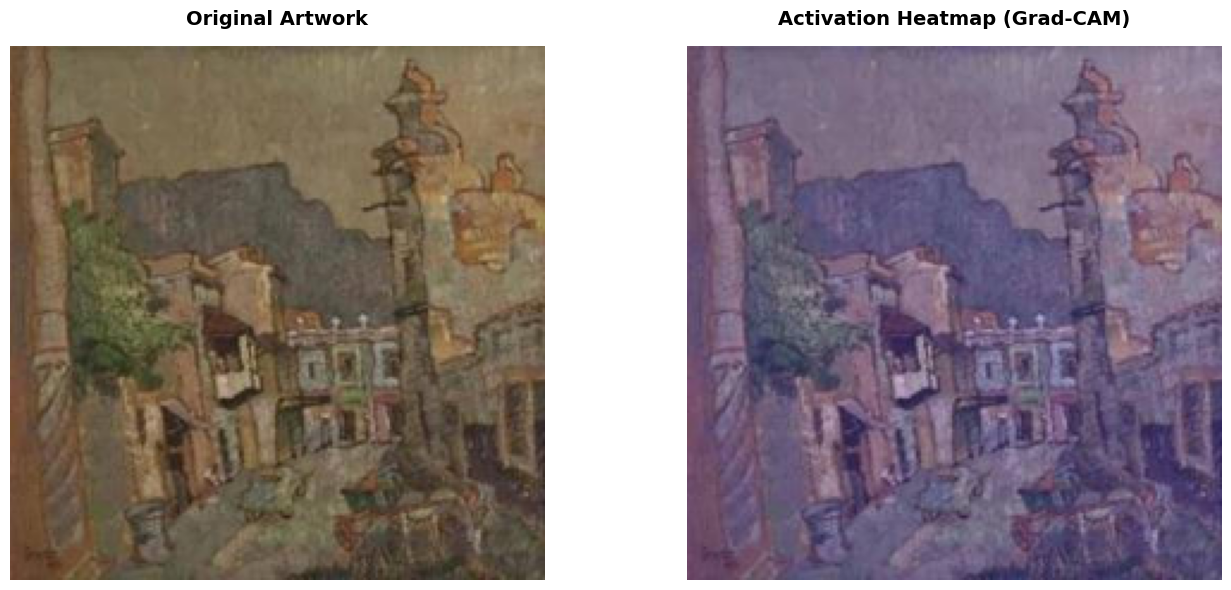

In [15]:
# Enhanced image preprocessing and visualization functions
INPUT_DIMENSIONS = (224, 224)

def prepare_image_for_inference(input_image):
    """Enhanced image preprocessing with format conversion"""
    if input_image.mode == 'RGBA':
        input_image = input_image.convert('RGB')
    resized_image = input_image.resize(INPUT_DIMENSIONS)
    array_representation = img_to_array(resized_image)
    batched_array = np.expand_dims(array_representation, axis=0)
    normalized_array = batched_array / 255.0
    return normalized_array

def generate_gradient_heatmap(input_array, trained_model, target_layer_name="conv_pw_13_relu", class_index=None):
    """Generate Grad-CAM heatmap for model interpretation"""
    target_conv_layer = trained_model.get_layer(target_layer_name)
    
    # Create gradient model
    gradient_model = tf.keras.models.Model(
        inputs=trained_model.input, 
        outputs=[target_conv_layer.output, trained_model.output]
    )
    
    # Compute gradients
    with tf.GradientTape() as gradient_tape:
        layer_output, model_predictions = gradient_model(input_array)
        if class_index is None:
            class_index = tf.argmax(model_predictions[0])
        target_class_output = model_predictions[:, class_index]
    
    # Calculate gradient importance
    gradients = gradient_tape.gradient(target_class_output, layer_output)
    averaged_gradients = tf.reduce_mean(gradients, axis=(0, 1, 2))

    # Generate heatmap
    feature_maps = layer_output[0]
    activation_heatmap = feature_maps @ averaged_gradients[..., tf.newaxis]
    activation_heatmap = tf.squeeze(activation_heatmap)

    # Normalize heatmap
    activation_heatmap = tf.maximum(activation_heatmap, 0) / tf.math.reduce_max(activation_heatmap)
    return activation_heatmap.numpy()

def create_enhanced_gradcam_visualization(source_image_path, generated_heatmap, overlay_intensity=0.4):
    """Create enhanced Grad-CAM visualization with improved styling"""
    original_image = cv2.imread(source_image_path)
    resized_original = cv2.resize(original_image, INPUT_DIMENSIONS)

    # Process heatmap
    heatmap_uint8 = np.uint8(255 * generated_heatmap)
    resized_heatmap = cv2.resize(heatmap_uint8, (resized_original.shape[1], resized_original.shape[0]))
    colored_heatmap = cv2.applyColorMap(resized_heatmap, cv2.COLORMAP_JET)
    overlay_result = colored_heatmap * overlay_intensity + resized_original

    # Enhanced visualization
    plt.style.use('default')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Original image display
    ax1.imshow(cv2.cvtColor(resized_original, cv2.COLOR_BGR2RGB))
    ax1.set_title("Original Artwork", fontsize=14, fontweight='bold', pad=15)
    ax1.axis('off')
    
    # Grad-CAM overlay display
    ax2.imshow(cv2.cvtColor(overlay_result.astype('uint8'), cv2.COLOR_BGR2RGB))
    ax2.set_title("Activation Heatmap (Grad-CAM)", fontsize=14, fontweight='bold', pad=15)
    ax2.axis('off')
    
    # Add subtle borders
    for ax in [ax1, ax2]:
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)
            spine.set_edgecolor('lightgray')
    
    plt.tight_layout()
    plt.show()

# Enhanced classification function
def perform_image_classification(image_input, classification_model):
    """Perform binary classification with confidence scoring"""
    preprocessed_input = prepare_image_for_inference(image_input)
    raw_prediction = classification_model.predict(preprocessed_input)
    predicted_class = np.round(raw_prediction[0][0]).astype(int)
    confidence_score = raw_prediction[0][0]
    return predicted_class, confidence_score, preprocessed_input

# Test classification on sample image
sample_image_path = '/kaggle/input/ai-and-human-art-classification/ai_art_classification/test/10018.jpg'

test_image = Image.open(sample_image_path)

predicted_class, confidence, processed_input = perform_image_classification(test_image, best_mobilenet_v1)
print(f"Classification Result: Class {predicted_class}, Confidence: {confidence * 100:.2f}%")

# Generate and display heatmap
activation_heatmap = generate_gradient_heatmap(processed_input, best_mobilenet_v1)

create_enhanced_gradcam_visualization(sample_image_path, activation_heatmap)

## Fine-tuned MobileNetV2 Architecture

In [18]:
pretrained_mobilenet_v2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
pretrained_mobilenet_v2.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_5[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [20]:
# Freeze all layers initially
pretrained_mobilenet_v2.trainable = False

# Optionally unfreeze last 10 layers instead of all for less memory usage & faster training
for layer in pretrained_mobilenet_v2.layers[-10:]:
    layer.trainable = True

# Build simplified classification head (dropout reduced to 0.2 for faster convergence)
x = GlobalAveragePooling2D()(pretrained_mobilenet_v2.output)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(1, activation='sigmoid')(x)

# Create final model
mobilenet_v2_classifier = Model(inputs=pretrained_mobilenet_v2.input, outputs=output)

# Compile with slightly higher learning rate to speed training (adjust if unstable)
mobilenet_v2_classifier.compile(
    optimizer=Adam(learning_rate=1e-4),  
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Callbacks
checkpoint = ModelCheckpoint('MobileNetV2_custom_classifier.keras', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, verbose=1, min_lr=1e-7)

batch_size = 32

training_history_v2 = mobilenet_v2_classifier.fit(
    training_flow,
    steps_per_epoch=training_flow.samples // batch_size,
    validation_data=validation_flow,
    validation_steps=validation_flow.samples // batch_size,
    epochs=2,  
    batch_size=batch_size,
    callbacks=[checkpoint, reduce_lr]
)

Epoch 1/2
137/852 ━━━━━━━━━━━━━━━━━━━━ 56:46 5s/step - accuracy: 0.8493 - loss: 0.3381

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 1: val_loss improved from inf to 1.61853, saving model to MobileNetV2_custom_classifier.keras
852/852 ━━━━━━━━━━━━━━━━━━━━ 776s 851ms/step - accuracy: 0.8918 - loss: 0.2616 - val_accuracy: 0.6349 - val_loss: 1.6185 - learning_rate: 1.0000e-04
Epoch 2/2
137/852 ━━━━━━━━━━━━━━━━━━━━ 56:15 5s/step - accuracy: 0.9334 - loss: 0.1708
Epoch 2: val_loss did not improve from 1.61853
852/852 ━━━━━━━━━━━━━━━━━━━━ 740s 822ms/step - accuracy: 0.9355 - loss: 0.1668 - val_accuracy: 0.6168 - val_loss: 2.4937 - learning_rate: 1.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Class: 1, Confidence: 69.06%


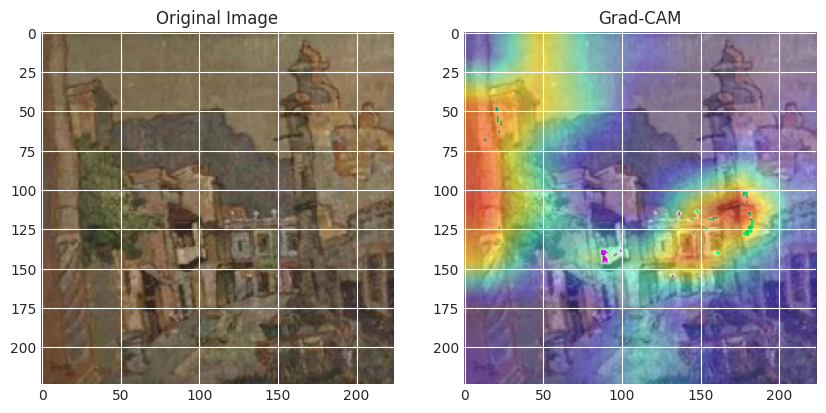

In [23]:
IMAGE_SIZE = (224, 224)

def preprocess_image(image):
    if image.mode == 'RGBA':
        image = image.convert('RGB')
    image = image.resize(IMAGE_SIZE)
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0
    return image

def make_gradcam_heatmap(img_array, model, last_conv_layer_name="out_relu", pred_index=None):
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = tf.keras.models.Model(
        inputs=model.input, 
        outputs=[last_conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    
    grads = tape.gradient(class_channel, conv_outputs)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, heatmap, alpha=0.4):
    img = cv2.imread(image_path)
    img = cv2.resize(img, IMAGE_SIZE)

    heatmap = np.uint8(255 * heatmap)

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title("Original Image")

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img.astype('uint8'), cv2.COLOR_BGR2RGB))
    plt.title("Grad-CAM")
    plt.show()

# Function to classify the image
def classify_image(image_data, model):
    processed_image = preprocess_image(image_data)
    prediction = model.predict(processed_image)
    class_label = np.round(prediction[0][0]).astype(int)
    confidence = prediction[0][0]
    return class_label, confidence, processed_image

image_path = '/kaggle/input/ai-and-human-art-classification/ai_art_classification/test/10018.jpg'

img = Image.open(image_path)

class_label, confidence, processed_image = classify_image(img, model)
print(f"Predicted Class: {class_label}, Confidence: {confidence * 100:.2f}%")

heatmap = make_gradcam_heatmap(processed_image, model)

display_gradcam(image_path, heatmap)